In [1]:
!pip install -U seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

np.random.seed(5)

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3 -m pip install --upgrade pip' command.


# Data Preparation

In [15]:
data = pd.read_csv('inpatientCharges.csv')

In [16]:
data.columns = ['DRG','Provider_Id', 'Provider_Name','Provider_StreetAddress','Provider_City',
               'Provider_State','Provider_Zipcode','Hospital_referral_region_desp',
                'Total_Discharges','Average_Covered_Charges','Average_Total_Payments',
                'Average_Medicare_Payment']

In [17]:
data['DRG'] = data['DRG'].astype('category')
data['Provider_State'] = data['Provider_State'].astype('category')
data['Provider_City'] = data['Provider_City'].astype('category')
data['Provider_Id'] = data['Provider_Id'].astype('category')
data['Average_Covered_Charges'] = (data['Average_Covered_Charges']
                              .str.replace(r'[^-+\d.]', '').astype(float))
data['Average_Total_Payments'] = (data['Average_Total_Payments']
                              .str.replace(r'[^-+\d.]', '').astype(float))
data['Average_Medicare_Payment'] = (data['Average_Medicare_Payment']
                              .str.replace(r'[^-+\d.]', '').astype(float))

I decide to keep my features from last assignment. However, instead of using mean as benchmark, I adapted median to robust my features against outliers.

In [18]:
benchmark = data.groupby(['Provider_State','DRG'])['Average_Total_Payments'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Payment_ByStateDRG']
benchmark.head()
feature1 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature1['ratio_amount1'] = feature1.Average_Total_Payments / feature1.Avg_Payment_ByStateDRG
feature1.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Avg_Payment_ByStateDRG,ratio_amount1
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,5658.33,1.021015
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,5658.33,1.022841
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,5658.33,0.960522
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,5658.33,0.957449
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,5658.33,1.000000


In [19]:
data['Patient_pay'] =data.Average_Total_Payments - data.Average_Medicare_Payment
benchmark = data.groupby(['Provider_State','DRG'])['Patient_pay'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Patient_Payment_ByStateDRG']
benchmark.head()
feature2 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature2['ratio_amount2'] = feature2.Patient_pay / feature2.Avg_Patient_Payment_ByStateDRG
feature2.tail()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Avg_Patient_Payment_ByStateDRG,ratio_amount2
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,803.365,0.915487
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,803.365,1.714837
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,803.365,2.048882
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,803.365,1.013923
163064,948 - SIGNS & SYMPTOMS W/O MCC,670068,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,4400 LONG PRAIRIE ROAD,FLOWER MOUND,TX,75028,TX - Dallas,12,15042.00,3539.75,2887.41,652.34,803.365,0.812009


In [20]:
data['Diff_between_patient_and_medicare_pay'] =data.Average_Medicare_Payment - data.Patient_pay
benchmark = data.groupby(['Provider_State','DRG'])['Diff_between_patient_and_medicare_pay'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_difference_in_patient_and_medicare_Payment_ByStateDRG']
benchmark.head()
feature3 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature3['ratio_amount3'] = feature3.Diff_between_patient_and_medicare_pay / feature3.Avg_difference_in_patient_and_medicare_Payment_ByStateDRG
feature3.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Avg_difference_in_patient_and_medicare_Payment_ByStateDRG,ratio_amount3
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1013.51,3750.22,3472.63,1.079937
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,810.86,4165.85,3472.63,1.199624
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,981.16,3472.63,3472.63,1.000000
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,1288.40,2840.76,3472.63,0.818043
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,806.89,4044.55,3472.63,1.164694


In [21]:
data['Payment_over_covered_ratio'] =data.Average_Total_Payments/data.Average_Covered_Charges
benchmark = data.groupby(['Provider_State','DRG'])['Payment_over_covered_ratio'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Payment_over_covered_ratio_ByStateDRG']
benchmark.head()
feature4 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature4['ratio_amount4'] = feature4.Payment_over_covered_ratio / feature4.Avg_Payment_over_covered_ratio_ByStateDRG
feature4.tail()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Payment_over_covered_ratio,Avg_Payment_over_covered_ratio_ByStateDRG,ratio_amount4
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,2335.92,0.144668,0.225312,0.642079
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,1272.08,0.185552,0.225312,0.823533
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,2412.36,0.145811,0.225312,0.647148
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,6033.99,0.265406,0.225312,1.177947
163064,948 - SIGNS & SYMPTOMS W/O MCC,670068,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,4400 LONG PRAIRIE ROAD,FLOWER MOUND,TX,75028,TX - Dallas,12,15042.00,3539.75,2887.41,652.34,2235.07,0.235324,0.225312,1.044436


In [22]:
data['Out_of_Pocket_ratio'] =data.Patient_pay/data.Average_Total_Payments
benchmark = data.groupby(['Hospital_referral_region_desp','DRG'])['Out_of_Pocket_ratio'].median().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Avg_Out_of_Pocket_ratio_ByRegionDRG']
benchmark.head()
feature5 = pd.merge(data, benchmark, how='left', on=['Hospital_referral_region_desp','DRG'])
# ratio
feature5['ratio_amount5'] = feature5.Out_of_Pocket_ratio / feature5.Avg_Out_of_Pocket_ratio_ByRegionDRG
feature5.tail()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Payment_over_covered_ratio,Out_of_Pocket_ratio,Avg_Out_of_Pocket_ratio_ByRegionDRG,ratio_amount5
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,2335.92,0.144668,0.193196,0.193196,1.000000
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,1272.08,0.185552,0.342070,0.188083,1.818716
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,2412.36,0.145811,0.288551,0.193196,1.493567
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,6033.99,0.265406,0.106295,0.182380,0.582824
163064,948 - SIGNS & SYMPTOMS W/O MCC,670068,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,4400 LONG PRAIRIE ROAD,FLOWER MOUND,TX,75028,TX - Dallas,12,15042.00,3539.75,2887.41,652.34,2235.07,0.235324,0.184290,0.182380,1.010473


In [23]:
data['ratio_amount1']=feature1['ratio_amount1']
data['ratio_amount2']=feature2['ratio_amount2']
data['ratio_amount3']=feature3['ratio_amount3']
data['ratio_amount4']=feature4['ratio_amount4']
data['ratio_amount5']=feature5['ratio_amount5']
data.head()


,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,...,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Payment_over_covered_ratio,Out_of_Pocket_ratio,ratio_amount1,ratio_amount2,ratio_amount3,ratio_amount4,ratio_amount5
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,4763.73,1013.51,3750.22,0.175264,0.175432,1.021015,0.971875,1.079937,0.817735,0.995540
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,4976.71,810.86,4165.85,0.382476,0.140104,1.022841,0.777550,1.199624,1.784531,0.759423
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,4453.79,981.16,3472.63,0.144699,0.180528,0.960522,0.940854,1.000000,0.675127,0.978540
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,...,4129.16,1288.40,2840.76,0.387016,0.237819,0.957449,1.235472,0.818043,1.805713,1.289084
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,...,4851.44,806.89,4044.55,0.178873,0.142602,1.000000,0.773743,1.164694,0.834572,0.772966


# K-means clustering

In [37]:
X = data.iloc[:, -5:]
model = KMeans(n_clusters=6)
model.fit(X)
labels = model.labels_
labels


array([5, 3, 5, ..., 4, 3, 5], dtype=int32)

In [38]:
pd.DataFrame(labels).value_counts(sort=False)

0      6124
1        83
2      1036
3     26224
4     27872
5    101726
dtype: int64

In [39]:
X_df = pd.DataFrame(X)
X_df.columns = ['Ratio1','Ratio2','Ratio3','Ratio4','Ratio5']
X_df['label'] = pd.DataFrame(labels)
X_df.head()

,Ratio1,Ratio2,Ratio3,Ratio4,Ratio5,label
0,1.021015,0.971875,1.079937,0.817735,0.995540,5
1,1.022841,0.777550,1.199624,1.784531,0.759423,3
2,0.960522,0.940854,1.000000,0.675127,0.978540,5
3,0.957449,1.235472,0.818043,1.805713,1.289084,3
4,1.000000,0.773743,1.164694,0.834572,0.772966,5


In [40]:
X_df.groupby('label').agg(['count','mean'])
X_stat = X_df.groupby('label').agg('describe')
X_stat

Ratio1                                                              \
          count      mean       std       min       25%       50%       75%   
label                                                                         
0        6124.0  1.204732  0.254372  0.610219  1.032424  1.150975  1.322348   
1          83.0  2.223463  1.515318  1.086699  1.427881  1.738734  2.247902   
2        1036.0  1.429731  0.419294  0.714166  1.136990  1.321896  1.627348   
3       26224.0  1.230268  0.297549  0.600990  1.006686  1.160260  1.401923   
4       27872.0  1.054414  0.172314  0.517695  0.950029  1.020565  1.121573   
5      101726.0  0.989375  0.130761  0.523254  0.906675  0.972505  1.043948   

                   Ratio2             ...    Ratio4               Ratio5  \
            max     count       mean  ...       75%        max     count   
label                                 ...                                  
0      3.532489    6124.0   3.403571  ...  1.241442   3.363421    6124.0   
1      9.338775      83.0  20.936080  ...  1.709414   9.715875      83.0   
2      3.729303    1036.0   7.617584  ...  1.329635   4.833698    1036.0   
3      5.751227   26224.0   0.914872  ...  1.860554  10.899874   26224.0   
4      2.466364   27872.0   1.695443  ...  1.186266   3.015036   27872.0   
5      2.106602  101726.0   0.943766  ...  1.085616   1.803224  101726.0   

                                                                               
           mean       std       min       25%       50%        75%        max  
label                                                                          
0      2.464173  0.829593  0.326067  1.930154  2.403618   2.933904   8.131893  
1      8.328389  4.646823  1.000000  4.451053  8.223559  12.479944  17.482269  
2      4.468498  2.044165  0.788209  3.075897  4.467650   5.639810  11.687887  
3      0.800855  0.223980  0.067105  0.641430  0.809167   0.982428   2.280223  
4      1.484051  0.325206  0.404455  1.269653  1.436332   1.658204   4.535179  
5      0.952348  0.190591  0.000000  0.848582  0.990399   1.056946   2.120741  

[6 rows x 40 columns]

In [41]:
X_stat = X_df.groupby('label').agg([np.mean, np.median, np.min, np.max])
                    #percentile(50), percentile(95)])
X_stat    

Ratio1                                   Ratio2             \
           mean    median      amin      amax       mean     median   
label                                                                 
0      1.204732  1.150975  0.610219  3.532489   3.403571   3.211375   
1      2.223463  1.738734  1.086699  9.338775  20.936080  17.671969   
2      1.429731  1.321896  0.714166  3.729303   7.617584   7.069637   
3      1.230268  1.160260  0.600990  5.751227   0.914872   0.905699   
4      1.054414  1.020565  0.517695  2.466364   1.695443   1.616134   
5      0.989375  0.972505  0.523254  2.106602   0.943766   0.952367   

                               Ratio3                                 \
            amin       amax      mean    median       amin      amax   
label                                                                  
0       1.032287   6.668403  0.672993  0.703395  -3.737557  3.329641   
1      12.467603  78.801555 -0.599061  0.141034 -16.472567  1.371006   
2       3.451614  15.599985  0.425055  0.546680  -4.728108  2.936179   
3       0.103985   4.072245  1.418397  1.325085   0.405520  7.120427   
4       0.783167   3.388147  0.837443  0.825439  -1.940891  2.565507   
5       0.000000   1.883413  1.034595  1.003075   0.362449  2.472819   

         Ratio4                                   Ratio5                      \
           mean    median      amin       amax      mean    median      amin   
label                                                                          
0      1.069433  1.013378  0.268861   3.363421  2.464173  2.403618  0.326067   
1      1.684143  1.329205  0.485966   9.715875  8.328389  8.223559  1.000000   
2      1.151652  1.078246  0.349844   4.833698  4.468498  4.467650  0.788209   
3      1.653946  1.568136  0.374625  10.899874  0.800855  0.809167  0.067105   
4      1.017681  0.995822  0.229839   3.015036  1.484051  1.436332  0.404455   
5      0.930443  0.939247  0.201518   1.803224  0.952348  0.990399  0.000000   

                  
            amax  
label             
0       8.131893  
1      17.482269  
2      11.687887  
3       2.280223  
4       4.535179  
5       2.120741

Group 1 and Group 2 seems to be the most suspicious- out of the means of 5 ratios, group1&2 rank first and second in three of the features. 

Feature 1(average payment amount relative to its peers) seems to do a decent job as it points out Group 1 is very suspicous

Feature 2(patient payment) amplifies the degree of suspiciousness of group 1(patient payment extremly high compare to its peers). Group 2 also seem worth investigating.

While feature 3 does not seem as extreme as other features, the mean of group 1 is negative. Recalling the feature 3 represents the difference between medicare payment and patient payment. The negative value here represents that on average the hospital in group 1 is requesting more money from patients than from Medicare, suggesting potential of taking advantage of asymmetric information.

Feature 4 on the other hand, is a relatively weak variable. There is not much indication of which group is worth investigating

Feature 5, similar to Feature 2 measures how much the patient is paying, but with the addition of relative to its total payment. Once again, group 1 and 2 strike out as the most suspicious groups, charging the customers a lot more compare to its peers.

However, While cluster 1 seems to be the most suspicious cluster. The cluster size may be a little too small. However, if we choose to include the cluster 2(the second most suspicious cluster), it would be too costly(too large of a size). Therefore, I decided to look into optimize number of clusters by using the elbow method


# Optimize number of clusters

In [60]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
     kmeans.fit(X)
     sse.append(kmeans.inertia_)


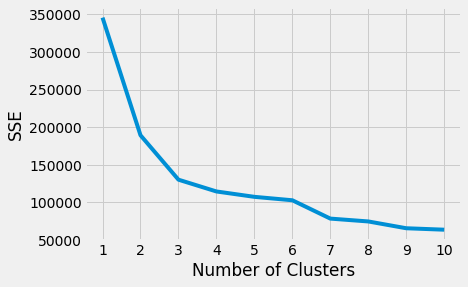

In [61]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

The SSE showed a flatter decline at 3 clusters. I decide to pursue with 4 clusters because I believe that would leave more room to identify fraud.

In [46]:
X = data.iloc[:, -5:]
model = KMeans(n_clusters=4)
model.fit(X)
labels = model.labels_
labels

array([2, 2, 2, ..., 0, 2, 2], dtype=int32)

In [47]:
pd.DataFrame(labels).value_counts(sort=False)

0     26696
1      3774
2    132303
3       292
dtype: int64

In [48]:
X_df = pd.DataFrame(X)
X_df.columns = ['Ratio1','Ratio2','Ratio3','Ratio4','Ratio5']
X_df['label'] = pd.DataFrame(labels)
X_df.head()

,Ratio1,Ratio2,Ratio3,Ratio4,Ratio5,label
0,1.021015,0.971875,1.079937,0.817735,0.995540,2
1,1.022841,0.777550,1.199624,1.784531,0.759423,2
2,0.960522,0.940854,1.000000,0.675127,0.978540,2
3,0.957449,1.235472,0.818043,1.805713,1.289084,2
4,1.000000,0.773743,1.164694,0.834572,0.772966,2


In [49]:
X_df.groupby('label').agg(['count','mean'])
X_stat = X_df.groupby('label').agg('describe')
X_stat

Ratio1                                                              \
          count      mean       std       min       25%       50%       75%   
label                                                                         
0       26696.0  1.076956  0.197541  0.517695  0.960608  1.035482  1.147114   
1        3774.0  1.270403  0.301938  0.648042  1.065857  1.206587  1.401985   
2      132303.0  1.037531  0.199380  0.523254  0.918315  0.992510  1.093287   
3         292.0  1.803027  0.941654  0.948603  1.311090  1.582467  1.992621   

                   Ratio2             ...    Ratio4               Ratio5  \
            max     count       mean  ...       75%        max     count   
label                                 ...                                  
0      5.751227   26696.0   1.890831  ...  1.179781   3.844939   26696.0   
1      3.532489    3774.0   4.612339  ...  1.274757   4.833698    3774.0   
2      4.913382  132303.0   0.950711  ...  1.243656  10.899874  132303.0   
3      9.338775     292.0  13.900661  ...  1.497268   9.715875     292.0   

                                                                              
           mean       std       min       25%       50%       75%        max  
label                                                                         
0      1.604084  0.419617  0.326067  1.332857  1.521330  1.806118   5.189554  
1      3.099884  1.319284  0.784705  2.264633  2.976369  3.680127  10.811375  
2      0.932000  0.213594  0.000000  0.807503  0.972045  1.050112   2.120741  
3      6.256085  3.591602  1.000000  3.749061  6.114756  8.213363  17.482269  

[4 rows x 40 columns]

In [50]:
X_stat = X_df.groupby('label').agg([np.mean, np.median, np.min, np.max])
                    #percentile(50), percentile(95)])
X_stat   

Ratio1                                   Ratio2                       \
           mean    median      amin      amax       mean     median      amin   
label                                                                           
0      1.076956  1.035482  0.517695  5.751227   1.890831   1.759248  0.874436   
1      1.270403  1.206587  0.648042  3.532489   4.612339   4.170179  1.455875   
2      1.037531  0.992510  0.523254  4.913382   0.950711   0.951132  0.000000   
3      1.803027  1.582467  0.948603  9.338775  13.900661  11.979830  7.759958   

                    Ratio3                                   Ratio4            \
            amax      mean    median       amin      amax      mean    median   
label                                                                           
0       4.287327  0.816301  0.804766  -1.940891  6.327619  1.017653  0.988043   
1      10.237102  0.586405  0.645807  -4.728108  3.329641  1.093285  1.034481   
2       2.862623  1.105801  1.028678   0.300178  7.120427  1.077656  1.000000   
3      78.801555 -0.038813  0.343682 -16.472567  1.438508  1.369142  1.162718   

                              Ratio5                                 
           amin       amax      mean    median      amin       amax  
label                                                                
0      0.229839   3.844939  1.604084  1.521330  0.326067   5.189554  
1      0.268861   4.833698  3.099884  2.976369  0.784705  10.811375  
2      0.201518  10.899874  0.932000  0.972045  0.000000   2.120741  
3      0.485966   9.715875  6.256085  6.114756  1.000000  17.482269

By setting the number of clusters to 4, Cluster 3 becomes the obvious group as it ranks first in every feature(and the only negative average) in feature3. Cluster 3 also identified a larger suspicious group than the previous cluster 1.(292 vs 83)
Feature 4 remain somewhat weak. However, mean of ratio 4 of cluster 3 is still about 30% greater than the other clusters.

Overall, all ratios pointed to the same direction to one suspicious group(cluster 3). We also identified a larger suspicious cluster by attempting to optimize the number of cluster.

